## Gradient Boosting Classifier on raw embeddings

В данной версии используется **сбалансированный датасет на 56 000 записей** (по 14 000 на каждый класс: match, weak_match, related, no_match). В отличие от baseline (RandomForest, 7 скалярных признаков), здесь используются **полные 384-мерные эмбеддинги** вместо сжатия в cosine similarity.

**Признаки (2689 dim):**

1. **rfq_embedding** (384 dim) — эмбеддинг текста RFQ (title + description + delivery_location + quantity)
2. **supplier_embedding** (384 dim) — эмбеддинг текста поставщика (name + description + country)
3. **multilingual_embedding** (384 dim) — эмбеддинг products + keywords
4. **rfq_types_mean_embedding** (384 dim) — усреднённый эмбеддинг типов поставщика из RFQ
5. **sup_types_mean_embedding** (384 dim) — усреднённый эмбеддинг типов поставщика
6. **rfq_category_embedding** (384 dim) — эмбеддинг категории RFQ
7. **sup_category_mean_embedding** (384 dim) — усреднённый эмбеддинг product_categories поставщика
8. **country_match_signal** (1 dim) — географическое совпадение (0 / 1 / 2)

Все эмбеддинги получены через **paraphrase-multilingual-MiniLM-L12-v2** (384 dim, 50+ языков).

**Классификатор:** HistGradientBoostingClassifier (оптимизирован для высокоразмерных данных).  
**Задача:** классификация типа совпадения RFQ–Supplier (match, weak_match, related, no_match).

---
## 1. Импорты и настройки

In [15]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer

---
## 2. Загрузка данных

In [16]:
data_path = Path("dataset/result_dataset_balanced_56k.csv")
df = pd.read_csv(data_path)

print("Форма датасета:", df.shape)
print("Колонки:", df.columns)
print("\nРаспределение классов:")
print(df["match_type"].value_counts())

Форма датасета: (56000, 16)
Колонки: Index(['rfq_id', 'rfq_title', 'rfq_description', 'quantity',
       'delivery_location', 'category_id', 'rfq_supplier_types',
       'supplier_name', 'supplier_country', 'distribution_area',
       'supplier_description', 'supplier_types', 'products',
       'product_categories', 'keywords', 'match_type'],
      dtype='object')

Распределение классов:
match_type
match         14000
no_match      14000
related       14000
weak_match    14000
Name: count, dtype: int64


---
## 3. Предобработка

In [17]:
def clean_array_field(s: str) -> str:
    if pd.isna(s):
        return ""
   
    s = str(s).strip()
    if s.startswith("{") and s.endswith("}"):
        s = s[1:-1]

    return s.replace(",", ", ")

array_columns = [
    "rfq_supplier_types", "supplier_types", "products", "product_categories", "keywords"
]
for col in array_columns:
    if col in df.columns:
        df[col] = df[col].apply(clean_array_field)

df.head()

,rfq_id,rfq_title,rfq_description,quantity,delivery_location,category_id,rfq_supplier_types,supplier_name,supplier_country,distribution_area,supplier_description,supplier_types,products,product_categories,keywords,match_type
0,000e6a46-ac45-4489-b237-12c15f5fb9a7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",Ich bin auf der Suche nach\n product : ...,10 - 50,DE,100033.0,"MANUFACTURER, WHOLESALER","WHY NOT?, LDA.",PT,international,The journey of Why Not? Bags began with the cr...,"Production, CustomerSpecificManufacturing","In-House Collection of Ready-to-Use Models, In...",Clothing and accessories,"Clothes and fashion model collections, High fa...",match
1,000e6a46-ac45-4489-b237-12c15f5fb9a7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",Ich bin auf der Suche nach\n product : ...,10 - 50,DE,100033.0,"MANUFACTURER, WHOLESALER",NY CORK,TR,international,The Nine Years is a premium Istanbul-based bra...,Production,"""CORPORATE GIFTS, HOME AND HOTEL SUPPLIES, W...",Design,"cork bags, cork handbags, cork accessories, wo...",match
2,000e6a46-ac45-4489-b237-12c15f5fb9a7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",Ich bin auf der Suche nach\n product : ...,10 - 50,DE,100033.0,"MANUFACTURER, WHOLESALER","FARL CORK UNIPESSOAL, LDA",PT,international,FARL CORK is a company established in late 201...,Production,"Natural yoga block, Fine grain cork block - Yo...",Wood and wood products,"Cortiça - produtos, yoga, cortiça granulada, R...",match
3,000e6a46-ac45-4489-b237-12c15f5fb9a7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",Ich bin auf der Suche nach\n product : ...,10 - 50,DE,100033.0,"MANUFACTURER, WHOLESALER",EMPREMTA BARCELONA,ES,europe,"At Empremta Barcelona, we specialize in the sa...","CustomerSpecificManufacturing, Wholesaler, Ser...",Customizable polyester drawstring backpack 190...,"""Marketing, advertising and sales""","Lightweight backpack, durable backpack, daily ...",match
4,000e6a46-ac45-4489-b237-12c15f5fb9a7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",Ich bin auf der Suche nach\n product : ...,10 - 50,DE,100033.0,"MANUFACTURER, WHOLESALER",KORK-STUDIO GROBE BRIGITTE GROBE,DE,europe,Everything made of cork has been our motto for...,Wholesaler,"Cork Dartboard, Cork box - Ø 90 x 60 mm, ""Cork...",Wood and wood products,"Sportartikel, Dartboards, Dartscheiben, Aufbew...",match


In [18]:
nan_counts = df.isna().sum()
has_nans = nan_counts.sum() > 0
if has_nans:
    print("Пропуски по колонкам (до заполнения):")
    for col in df.columns:
        if nan_counts[col] > 0:
            print(f"  {col}: {nan_counts[col]}")
else:
    print("Пропусков нет.")

Пропуски по колонкам (до заполнения):
  quantity: 1
  category_id: 50
  distribution_area: 11080
  supplier_description: 3054


In [19]:
text_columns = [
    "rfq_title", "rfq_description", "delivery_location", "quantity",
    "rfq_supplier_types", "supplier_name", "supplier_country", "distribution_area",
    "supplier_description", "supplier_types", "products", "product_categories", "keywords"
]
for col in text_columns:
    if col in df.columns:
        df[col] = df[col].fillna("").astype(str)

---
## 3.0.1. Географический признак: country_match_signal

Используем `distribution_area` поставщика и справочник `distribution_areas_country_codes.csv` для создания признака совпадения стран.

Правила:
1. Если `distribution_area` пустая — используем `supplier_country` как единственную страну доставки
2. Если `supplier_country == delivery_location` — **strong signal** (значение 2)
3. Если `delivery_location` входит в множество стран `distribution_area` — **medium signal** (значение 1)
4. Иначе — 0

In [20]:
dist_areas_df = pd.read_csv("dataset/distribution_areas_country_codes.csv")

dist_area_map = {}
for _, row in dist_areas_df.iterrows():
    area = row["distribution_area"]
    countries_str = str(row["delivery_locations"]).strip("{}")
    dist_area_map[area] = set(countries_str.split(","))

print("Distribution area => number of countries:")
for area, countries in dist_area_map.items():
    print(f"  {area}: {len(countries)} countries")


def compute_country_signal(row):
    delivery_loc = str(row["delivery_location"]).strip()
    supplier_country = str(row["supplier_country"]).strip()
    distribution_area = str(row["distribution_area"]).strip()

    if supplier_country and delivery_loc and supplier_country == delivery_loc:
        return 2

    if distribution_area and distribution_area in dist_area_map:
        effective_countries = dist_area_map[distribution_area]
    else:
        effective_countries = {supplier_country} if supplier_country else set()

    if delivery_loc in effective_countries:
        return 1

    return 0


df["country_match_signal"] = df.apply(compute_country_signal, axis=1)

print(f"\ncountry_match_signal distribution:")
print(df["country_match_signal"].value_counts().sort_index())
print(f"\ncountry_match_signal by match_type:")
print(df.groupby("match_type")["country_match_signal"].mean())

Distribution area => number of countries:
  europe: 149 countries
  international: 155 countries
  national: 134 countries
  regional: 109 countries

country_match_signal distribution:
country_match_signal
0    10313
1    36011
2     9676
Name: count, dtype: int64

country_match_signal by match_type:
match_type
match         1.001143
no_match      1.026214
related       0.953357
weak_match    0.973786
Name: country_match_signal, dtype: float64


In [ ]:
df["rfq_text"] = (
    df["rfq_title"].astype(str) + " "
    + df["rfq_description"].astype(str) + " "
    + df["delivery_location"].astype(str) + " "
    + df["quantity"].astype(str)
)

df["supplier_text"] = (
    df["supplier_name"].astype(str) + " "
    + df["supplier_description"].astype(str) + " "
    + df["supplier_country"].astype(str)
)

# нужно что-то сделать когда пусто
df["multilingual_text"] = (
    df["products"].astype(str) + " "
    + df["keywords"].astype(str)
)

df[["rfq_text", "supplier_text", "multilingual_text"]].head(10)

,rfq_text,supplier_text,multilingual_text
0,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...","WHY NOT?, LDA. The journey of Why Not? Bags be...","In-House Collection of Ready-to-Use Models, In..."
1,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",NY CORK The Nine Years is a premium Istanbul-b...,"""CORPORATE GIFTS, HOME AND HOTEL SUPPLIES, W..."
2,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...","FARL CORK UNIPESSOAL, LDA FARL CORK is a compa...","Natural yoga block, Fine grain cork block - Yo..."
3,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...","EMPREMTA BARCELONA At Empremta Barcelona, we s...",Customizable polyester drawstring backpack 190...
4,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",KORK-STUDIO GROBE BRIGITTE GROBE Everything ma...,"Cork Dartboard, Cork box - Ø 90 x 60 mm, ""Cork..."
5,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",NY CORK TEKSTIL DERI ITHALAT IHRACAT SAN VE TI...,"""CORK GIFTS PRODUCTS, HOME AND HOTEL DECORATI..."
6,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",AMADIACORK DESIGNED BY NATURE Welcome to Amad...,"Cork fabric - Colorful cork fabrics, Cork Fabr..."
7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",MONARCH CORK & TEXTILE Monarch Textile & Bag '...,"Smyrna Cork Handbag - SKU: MC-A25N, Smyrna Cor..."
8,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",NY CORK TEKSTIL ITH IHR SAN VE TIC AS NY-Cork ...,"Cork Shoulder Bag with Eco-Friendly Material, ..."
9,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",KORKALLEE.DE - ECO-FASHION AUS KORK KorkAllee....,


---
## 3.1. Raw Multilingual Embeddings

Используем модель **paraphrase-multilingual-MiniLM-L12-v2** (384 dim, 50+ языков) для кодирования текстовых полей. В отличие от baseline, здесь **не** сжимаем эмбеддинги в скалярные cosine similarity, а используем полные 384-мерные вектора как признаки.

Эмбеддинги из этого блока (5 × 384 = 1920 dim):
1. **rfq_embedding** (384) — эмбеддинг текста RFQ
2. **supplier_embedding** (384) — эмбеддинг текста поставщика
3. **multilingual_embedding** (384) — эмбеддинг products + keywords
4. **rfq_types_mean_embedding** (384) — усреднённый эмбеддинг типов поставщика из RFQ
5. **sup_types_mean_embedding** (384) — усреднённый эмбеддинг типов поставщика

In [22]:
EMB_DIM = 384
ml_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

print("Кодируем rfq_text...")
rfq_embeddings = ml_model.encode(
    df["rfq_text"].tolist(), show_progress_bar=True, batch_size=64
)

print("Кодируем supplier_text...")
supplier_embeddings = ml_model.encode(
    df["supplier_text"].tolist(), show_progress_bar=True, batch_size=64
)

print("Кодируем multilingual_text (products + keywords)...")
multilingual_embeddings = ml_model.encode(
    df["multilingual_text"].tolist(), show_progress_bar=True, batch_size=64
)

print(f"  rfq_embeddings shape: {rfq_embeddings.shape}")
print(f"  supplier_embeddings shape: {supplier_embeddings.shape}")
print(f"  multilingual_embeddings shape: {multilingual_embeddings.shape}")

print("\nКодируем supplier types...")
all_type_items = set()
for col in ["rfq_supplier_types", "supplier_types"]:
    for val in df[col]:
        for item in str(val).split(", "):
            item = item.strip()
            if item:
                all_type_items.add(item)

all_type_items = sorted(all_type_items)
print(f"  Уникальных типов: {len(all_type_items)}")

type_embeddings_arr = ml_model.encode(all_type_items, show_progress_bar=True, batch_size=64)
type_emb_map = {item: emb for item, emb in zip(all_type_items, type_embeddings_arr)}


def get_mean_type_embedding(types_str):
    items = [t.strip() for t in str(types_str).split(", ") if t.strip()]
    embs = [type_emb_map[t] for t in items if t in type_emb_map]
    if not embs:
        return np.zeros(EMB_DIM)
    return np.mean(embs, axis=0)


print("Вычисляем mean type embeddings для rfq и supplier...")
rfq_type_embeddings = np.array([get_mean_type_embedding(v) for v in df["rfq_supplier_types"]])
sup_type_embeddings = np.array([get_mean_type_embedding(v) for v in df["supplier_types"]])

print(f"  rfq_type_embeddings shape: {rfq_type_embeddings.shape}")
print(f"  sup_type_embeddings shape: {sup_type_embeddings.shape}")

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1768.17it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Кодируем rfq_text...


Batches: 100%|██████████| 875/875 [01:19<00:00, 11.06it/s]


Кодируем supplier_text...


Batches: 100%|██████████| 875/875 [01:32<00:00,  9.50it/s]


Кодируем multilingual_text (products + keywords)...


Batches: 100%|██████████| 875/875 [01:53<00:00,  7.73it/s] 


  rfq_embeddings shape: (56000, 384)
  supplier_embeddings shape: (56000, 384)
  multilingual_embeddings shape: (56000, 384)

Кодируем supplier types...
  Уникальных типов: 15


Batches: 100%|██████████| 1/1 [00:00<00:00, 44.62it/s]

Вычисляем mean type embeddings для rfq и supplier...


  rfq_type_embeddings shape: (56000, 384)
  sup_type_embeddings shape: (56000, 384)


---
## 3.2. Категориальные эмбеддинги

RFQ содержит `category_id` — ID категории из справочника `categories.csv` (немецкие названия).  
Supplier содержит `product_categories` — массив строк на **любом языке** (DE, EN, и др.).

Вместо сжатия в скалярные `category_match` / `category_best_sim`, используем полные 384-мерные эмбеддинги:

1. **rfq_category_embedding** (384 dim) — эмбеддинг категории RFQ из справочника (по `category_id`)
2. **sup_category_mean_embedding** (384 dim) — усреднённый эмбеддинг всех `product_categories` поставщика

In [23]:
categories_df = pd.read_csv("dataset/categories.csv")
cat_id_to_name = dict(zip(categories_df["category_id"], categories_df["category_name"]))
cat_names = categories_df["category_name"].tolist()
cat_ids = categories_df["category_id"].tolist()

print(f"Категорий в справочнике: {len(cat_names)}")
print("Кодируем категории справочника...")
cat_embeddings = ml_model.encode(cat_names, show_progress_bar=True, batch_size=64)
cat_emb_map = {cid: emb for cid, emb in zip(cat_ids, cat_embeddings)}

all_prod_cats = set()
for val in df["product_categories"]:
    for item in str(val).split(", "):
        item = item.strip()
        if item:
            all_prod_cats.add(item)

all_prod_cats = sorted(all_prod_cats)
print(f"Уникальных product_categories в датасете: {len(all_prod_cats)}")
print("Кодируем product_categories...")
prod_cat_embeddings = ml_model.encode(all_prod_cats, show_progress_bar=True, batch_size=64)
prod_cat_emb_map = {pc: emb for pc, emb in zip(all_prod_cats, prod_cat_embeddings)}


def get_rfq_category_embedding(category_id):
    if pd.isna(category_id) or category_id == "":
        return np.zeros(EMB_DIM)
    cid = int(category_id)
    return cat_emb_map.get(cid, np.zeros(EMB_DIM))


def get_mean_prod_cat_embedding(prod_cats_str):
    items = [t.strip() for t in str(prod_cats_str).split(", ") if t.strip()]
    embs = [prod_cat_emb_map[t] for t in items if t in prod_cat_emb_map]
    if not embs:
        return np.zeros(EMB_DIM)
    return np.mean(embs, axis=0)


print("\nВычисляем category embeddings...")
rfq_category_embeddings = np.array([get_rfq_category_embedding(v) for v in df["category_id"]])
sup_category_embeddings = np.array([get_mean_prod_cat_embedding(v) for v in df["product_categories"]])

print(f"  rfq_category_embeddings shape: {rfq_category_embeddings.shape}")
print(f"  sup_category_embeddings shape: {sup_category_embeddings.shape}")

feature_group_names = [
    "rfq_emb", "supplier_emb", "multilingual_emb",
    "rfq_types_emb", "sup_types_emb",
    "rfq_category_emb", "sup_category_emb",
    "country_match_signal",
]
feature_group_sizes = [384, 384, 384, 384, 384, 384, 384, 1]

total_features = sum(feature_group_sizes)
print(f"\nМодель: paraphrase-multilingual-MiniLM-L12-v2")
print(f"Всего признаков: {total_features}")
print(f"Группы признаков:")
for name, size in zip(feature_group_names, feature_group_sizes):
    print(f"  {name}: {size} dim")

Категорий в справочнике: 112
Кодируем категории справочника...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches: 100%|██████████| 2/2 [00:00<00:00, 40.46it/s]


Уникальных product_categories в датасете: 257
Кодируем product_categories...


Batches: 100%|██████████| 5/5 [00:00<00:00, 66.79it/s]


Вычисляем category embeddings...


  rfq_category_embeddings shape: (56000, 384)
  sup_category_embeddings shape: (56000, 384)

Модель: paraphrase-multilingual-MiniLM-L12-v2
Всего признаков: 2689
Группы признаков:
  rfq_emb: 384 dim
  supplier_emb: 384 dim
  multilingual_emb: 384 dim
  rfq_types_emb: 384 dim
  sup_types_emb: 384 dim
  rfq_category_emb: 384 dim
  sup_category_emb: 384 dim
  country_match_signal: 1 dim


---
## 4. Построение матрицы признаков и разбиение (80 / 20)

Собираем все 7 групп эмбеддингов (по 384 dim каждая) + 1 скалярный признак в единую матрицу (2689 dim).

Используется **GroupShuffleSplit** по ключу `rfq_id`: все строки одного RFQ попадают в одну выборку, чтобы избежать data leakage.

In [24]:
X = np.hstack([
    rfq_embeddings,
    supplier_embeddings,
    multilingual_embeddings,
    rfq_type_embeddings,
    sup_type_embeddings,
    rfq_category_embeddings,
    sup_category_embeddings,
    df[["country_match_signal"]].values,
])

print(f"Матрица признаков X shape: {X.shape}")

y = df["match_type"]
groups = df["rfq_id"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train = X[train_idx]
y_train = y.iloc[train_idx]
X_test = X[test_idx]
y_test = y.iloc[test_idx]

print(f"Размер обучающей выборки (train): {len(X_train)}")
print(f"Размер тестовой выборки (test): {len(X_test)}")
print(f"Количество признаков: {X_train.shape[1]}")

print(f"\nРаспределение классов (train):\n{y_train.value_counts()}")
print(f"\nРаспределение классов (test):\n{y_test.value_counts()}")

Матрица признаков X shape: (56000, 2689)
Размер обучающей выборки (train): 44735
Размер тестовой выборки (test): 11265
Количество признаков: 2689

Распределение классов (train):
match_type
related       11223
no_match      11216
match         11211
weak_match    11085
Name: count, dtype: int64

Распределение классов (test):
match_type
weak_match    2915
match         2789
no_match      2784
related       2777
Name: count, dtype: int64


---
## 5. Модель и обучение

Признаки (2689 dim): 7 групп эмбеддингов по 384 dim + 1 скалярный.

Классификатор: **HistGradientBoostingClassifier** — histogram-based gradient boosting, оптимизированный для больших датасетов и высокой размерности. В отличие от стандартного `GradientBoostingClassifier`, использует бинаризацию признаков (256 бинов), что значительно ускоряет обучение при ~2700 признаках.

In [29]:
clf = HistGradientBoostingClassifier(
    max_iter=300,
    learning_rate=0.1,
    max_depth=6,
    min_samples_leaf=10,
    max_bins=255,
    random_state=42,
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

---
## 6. Оценка качества и визуализация

In [30]:
print("Test — classification report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Test — accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nConfusion matrix (test):")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Test — classification report:
              precision    recall  f1-score   support

       match       0.31      0.03      0.05      2789
    no_match       0.55      0.12      0.20      2784
     related       0.28      0.66      0.40      2777
  weak_match       0.29      0.39      0.33      2915

    accuracy                           0.30     11265
   macro avg       0.36      0.30      0.24     11265
weighted avg       0.36      0.30      0.24     11265

Test — accuracy: 0.2993

Confusion matrix (test):
[[  70  147 1525 1047]
 [  46  348 1446  944]
 [  57   60 1824  836]
 [  50   73 1662 1130]]


In [32]:
baseline_acc = accuracy_score(y_test, y_pred)

rng = np.random.RandomState(42)
group_importances = {}
offset = 0
for name, size in zip(feature_group_names, feature_group_sizes):
    X_test_shuffled = X_test.copy()
    idx = rng.permutation(len(X_test_shuffled))
    X_test_shuffled[:, offset:offset + size] = X_test_shuffled[idx, offset:offset + size]
    shuffled_acc = accuracy_score(y_test, clf.predict(X_test_shuffled))
    group_importances[name] = baseline_acc - shuffled_acc
    offset += size

print("Важность признаков по группам (permutation importance — drop in accuracy):")
for name, imp in sorted(group_importances.items(), key=lambda x: -x[1]):
    print(f"  {name}: {imp:+.4f}")

Важность признаков по группам (permutation importance — drop in accuracy):
  multilingual_emb: +0.0166
  supplier_emb: +0.0159
  rfq_emb: +0.0124
  rfq_category_emb: +0.0119
  sup_category_emb: +0.0060
  rfq_types_emb: +0.0025
  sup_types_emb: +0.0009
  country_match_signal: +0.0003


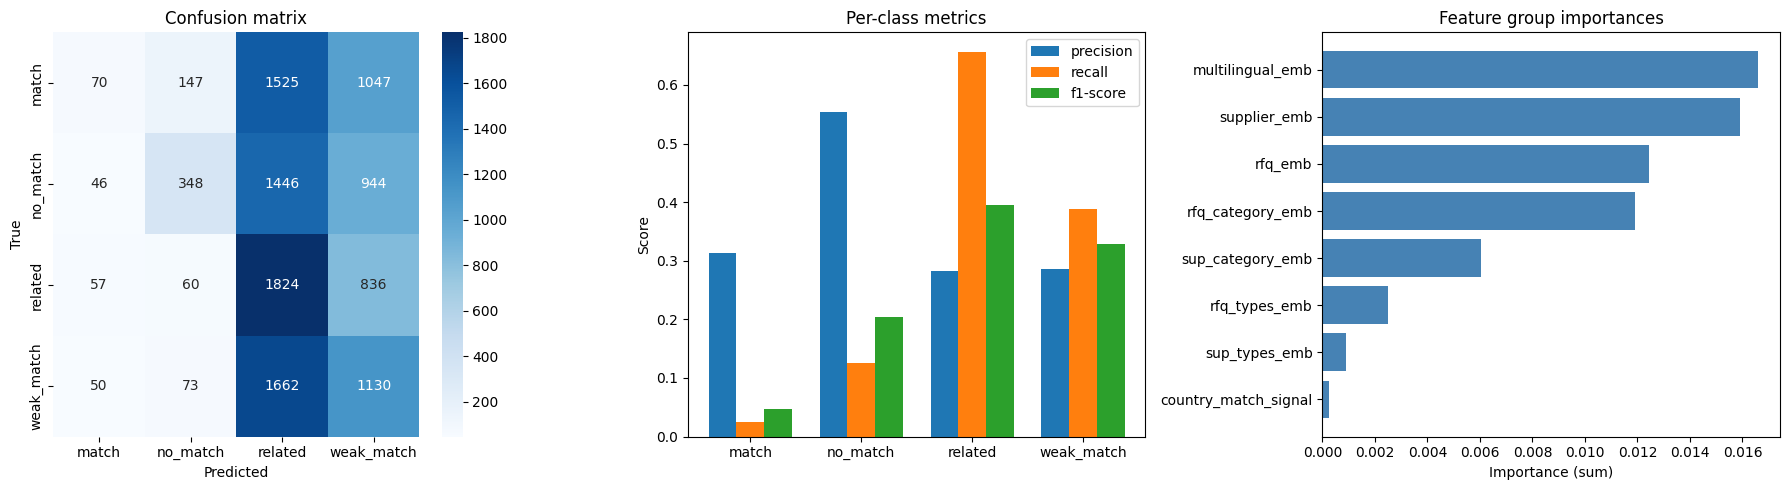

In [33]:
labels = sorted(y.unique())
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(
    cm, xticklabels=labels, yticklabels=labels, annot=True, fmt="d",
    cmap="Blues", ax=axes[0]
)
axes[0].set_title("Confusion matrix")
axes[0].set_ylabel("True")
axes[0].set_xlabel("Predicted")

report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
metrics = ["precision", "recall", "f1-score"]
x = np.arange(len(labels))
width = 0.25
for i, m in enumerate(metrics):
    vals = [report[l].get(m, 0) for l in labels]
    axes[1].bar(x + i * width, vals, width, label=m)
    
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(labels)
axes[1].set_ylabel("Score")
axes[1].set_title("Per-class metrics")
axes[1].legend()

sorted_groups = sorted(group_importances.items(), key=lambda x: -x[1])
group_names_sorted = [g[0] for g in sorted_groups]
group_vals_sorted = [g[1] for g in sorted_groups]
axes[2].barh(group_names_sorted[::-1], group_vals_sorted[::-1], color="steelblue")
axes[2].set_xlabel("Importance (sum)")
axes[2].set_title("Feature group importances")

plt.tight_layout()
plt.show()

---
## Выводы

### Данные и признаки

Ключевое отличие от baseline: вместо сжатия эмбеддингов в 7 скалярных cosine similarity, модель работает с **полными 384-мерными эмбеддингами** — всего **2689 признаков** (7 × 384 + 1 скалярный `country_match_signal`).

| Группа признаков | Размерность | Описание |
|---|---|---|
| `rfq_emb` | 384 | Эмбеддинг текста RFQ |
| `supplier_emb` | 384 | Эмбеддинг текста поставщика |
| `multilingual_emb` | 384 | Эмбеддинг products + keywords |
| `rfq_types_emb` | 384 | Mean эмбеддинг типов из RFQ |
| `sup_types_emb` | 384 | Mean эмбеддинг типов поставщика |
| `rfq_category_emb` | 384 | Эмбеддинг категории RFQ |
| `sup_category_emb` | 384 | Mean эмбеддинг product_categories |
| `country_match_signal` | 1 | Географическое совпадение (0/1/2) |

### Модель

**HistGradientBoostingClassifier** — histogram-based gradient boosting из sklearn. Выбран вместо стандартного `GradientBoostingClassifier` из-за значительно более высокой скорости на высокоразмерных данных.

Гиперпараметры:
- `max_iter=300` — количество итераций (деревьев)
- `learning_rate=0.1` — скорость обучения
- `max_depth=6` — максимальная глубина дерева
- `min_samples_leaf=10` — регуляризация

### Результаты

- **Test accuracy:** 0.30
- **Test macro-F1:** 0.24

Confusion matrix показывает сильный дисбаланс предсказаний: модель массово предсказывает `related` (6457 из 11265 предсказаний) и `weak_match`, почти не предсказывая `match` (recall всего 0.03). Лучшие метрики у класса `related` (F1 = 0.40), худшие — у `match` (F1 = 0.05).

### Сравнение с предыдущими экспериментами

| Метрика | RandomForest (7 feat) | GradientBoosting (7 feat) | **HistGB (2689 raw emb)** |
|---|---|---|---|
| Test accuracy | 0.31 | 0.33 | **0.30** |
| Test macro-F1 | 0.31 | 0.33 | **0.24** |

### Анализ: почему raw embeddings ухудшили результат

Вопреки ожиданиям, использование полных 384-мерных эмбеддингов **ухудшило** качество по сравнению с 7 скалярными cosine similarity. Основные причины:

1. **Косинусное сходство — «готовый признак»:** когда мы вычисляем `cos_rfq_supplier`, мы явно выражаем семантическую близость одним числом. Дерево может эффективно разбить по нему. С raw эмбеддингами модели нужно «переизобрести» эту метрику из отдельных координат (на большой размерности), что при ограниченном числе деревьев и глубине нереалистично.

2. **Переобучение и шум:** большое количество признаков при относительно небольшом датасете (56k) приводит к тому, что модель подхватывает шумовые паттерны вместо реальных зависимостей.

### Вывод

Для tree-based моделей (RandomForest, GradientBoosting) **предварительно вычисленные similarity-признаки работают лучше, чем raw эмбеддинги**. Cosine similarity выступает как эффективный feature engineering, «конденсируя» высокоразмерную семантическую информацию в удобную для деревьев скалярную метрику.

Для работы с raw эмбеддингами необходимы нейросетевые модели (например, Transformer-based), способные обучать внутренние представления и вычислять сложные функции расстояния между эмбеддингами.